In [1]:
import glob
import os
from random import *
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import torch

import torchio as tio

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, partition_dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    LoadNiftid,
    ToTensord, Spacingd
)
from monai.utils import first, set_determinism

print_config()
print('TorchIO version:', tio.__version__)

MONAI version: 0.4.0
Numpy version: 1.19.2
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.0.1
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.55.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

TorchIO version: 0.18.15


In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "./data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./data


In [4]:
data_dir = os.path.join(root_dir, "nifti_data")
train_images = sorted(glob.glob(os.path.join(data_dir, "image", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "mask", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

In [5]:
histogram_landmarks_path = 'landmarks.npy'
landmarks = tio.HistogramStandardization.train(
    train_images,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 99/99 [00:57<00:00,  1.72it/s]
Trained landmarks: [  0.      3.018   7.291   9.563  11.927  17.35   25.007  34.854  45.461
  50.772  56.081  67.786 100.   ]



In [29]:
### image augmentation transform with monai and torchio API

train_transforms_monai = [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.0,1.0,1.0), mode=("bilinear","nearest")),
        ToTensord(keys=["image", "label"]),
]

train_transforms_io = [
        tio.CropOrPad((96, 96, 32), mask_name='label', include=["image", "label"]),
        tio.HistogramStandardization({'image': landmarks}, include=["image"]),
        tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
        tio.RandomNoise(p=0.1, include=["image"]),
        tio.RandomFlip(axes=(0,), include=["image", "label"]),
]

validation_transforms_monai = [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
]

validation_transforms_io = [
    tio.CropOrPad((96, 96, 32), mask_name='label', include=["image", "label"]),
    tio.HistogramStandardization({'image': landmarks}, include=["image"]),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean, include=["image"]),
]

In [30]:
train_transforms = Compose(train_transforms_monai + train_transforms_io)
val_transforms = Compose(validation_transforms_monai + validation_transforms_io )

In [31]:
train_data, val_data, test_data = partition_dataset(data_dicts, ratios = [0.9, 0.05, 0.05], shuffle = True)

train_ds = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=8)
val_ds = CacheDataset(data=val_data, transform=val_transforms, cache_rate=1.0, num_workers=8)
test_ds = CacheDataset(data=test_data, transform=val_transforms, cache_rate=1.0, num_workers=8)

print('\n'+'Training set:', len(train_data), 'subjects')
print('Validation set:', len(val_data), 'subjects')
print('Validation set:', len(test_data), 'subjects')

100%|██████████| 5/5 [00:00<00:00,  7.87it/s]
Training set: 89 subjects
Validation set: 5 subjects
Validation set: 5 subjects



In [32]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

In [33]:
### custom defined visualization function
def plot_image_and_mask(imgset, maskset):
    fig, axs = plt.subplots(len(imgset[0,0,:]),2, figsize=(10,100))
    count = 0
    for i in range(len(imgset[0,0,:])):
        axs[count][0].title.set_text("MRI T2 WI rectal") # set title
        axs[count][0].imshow(imgset[:,:,i],cmap='gray') # show MRI 
        axs[count][1].title.set_text("Mask") # plot title on the mask 
        axs[count][1].imshow(maskset[:,:,i]) # Show corresponding mask
        count += 1
    fig.tight_layout()

In [34]:
def image_visualization(batch):
    index1 = randint(0,len(batch["image"])-1)
    subject_img, subject_label = (batch["image"][index1][0], batch["label"][index1][0])
    print(f"image shape: {subject_img.shape}, label shape: {subject_label.shape}")
    plot_image_and_mask(subject_img, subject_label)

image shape: torch.Size([96, 96, 32]), label shape: torch.Size([96, 96, 32])


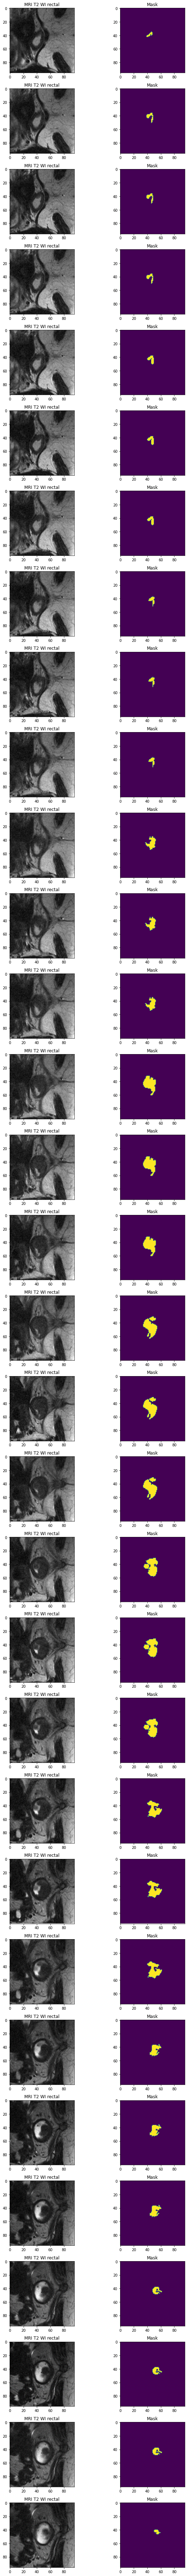

In [35]:
### plot a batch of training images and masks 
batch_train = next(iter(train_loader))
image_visualization(batch_train)

image shape: torch.Size([96, 96, 32]), label shape: torch.Size([96, 96, 32])


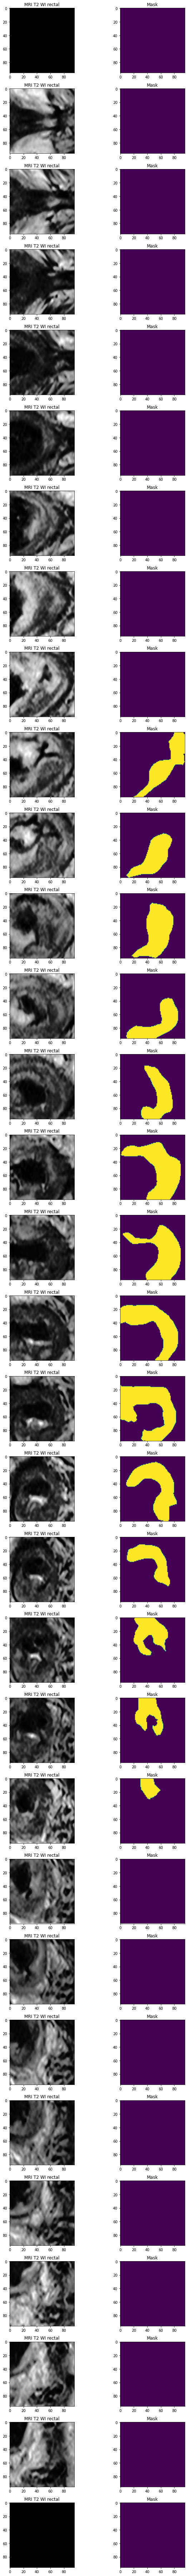

In [36]:
### plot a batch of validation images and masks 
batch_valid = next(iter(val_loader))
image_visualization(batch_valid)

In [ ]:
# standard PyTorch program style: create UNet
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
    dropout=0.4
)

# model summary
from torchsummaryX import summary
summary(model, torch.zeros((4, 1, 192, 192, 16), device="cpu"))

device = torch.device("cuda:0")
model.to(device)

## loss function and optimizer: DiceLoss and Adam optimizer
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

In [ ]:
## train start

epoch_num = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (192, 192, 16)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f}  at epoch: {best_metric_epoch}")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (192, 192, 16)
        sw_batch_size = 1
        test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, rand]
        j = randint(0, len(test_data["image"][0,0,0,0,:])-1)
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, j], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, j])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, j])
        plt.show()